### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging



# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


# Used for making the graph to visualize our problem
# import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later

data_vessel = {
    "env": None,
    "name": 'Vessel M9',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "type": None,
    "B": 11.45,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.75,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat":None,
    "P_installed": 2200.0,   
    "P_tot_given": None, # kW
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 1990,
    "current_year":None
}             



In [4]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 8, 200)          # ship sailing speeds to water, (m/s)
h_0 = [10, 7.5, 5, 3.5]                 # water depths,(m)
C_year = [1970, 1980, 1990, 2000, 2010, 2020]   # engine construction years



### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(C_year, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"C_year": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,C_year,h_0,V_s
4795,2020,3.5,7.841206
4796,2020,3.5,7.880905
4797,2020,3.5,7.920603
4798,2020,3.5,7.960302
4799,2020,3.5,8.000000


In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    C_year = row['C_year']
    data_vessel_i = data_vessel.copy()
    data_vessel_i['C_year'] = C_year
    vessel = TransportResource(**data_vessel_i)
    
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    P_tot = vessel.calculate_total_power_required(V_s)
    vessel.emission_factors_general()
    vessel.correction_factors(V_s)
    vessel.calculate_emission_factors_total(V_s)
    Fuel_g_m = vessel.calculate_fuel_use_g_m(V_s)
    [emission_g_m_CO2,emission_g_m_PM10,emission_g_m_NOX] = vessel.calculate_emission_rates_g_m(V_s)
    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['P_tot'] = P_tot
    result['Fuel_g_km'] = Fuel_g_m * 1000
    result['emission_g_km_CO2'] = emission_g_m_CO2 * 1000
    result['emission_g_km_PM10'] = emission_g_m_PM10 * 1000
    result['emission_g_km_NOX'] = emission_g_m_NOX * 1000
    results.append(result)

11it [00:00, 105.12it/s]

9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458
9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817
9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897
9.998660427282221
9.998527692550514
9.998388435791217


33it [00:00, 108.07it/s]

9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196
9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925
9.995975278461515
9.995742651600562
9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166
9.994477326793051


54it [00:00, 94.62it/s] 

9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267
9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786
9.989268158847185
9.988883184523226
9.988491160742221


75it [00:00, 97.57it/s]

9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163
9.986424975745141
9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405
9.980739581648615
9.980219182217725
9.979691575338782


98it [00:00, 103.17it/s]

9.979156753710887
9.978614710117126
9.97806543742259
9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262
9.975210393219655
9.974617600445379
9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126
9.96693466362051
9.966246778956775


109it [00:01, 102.22it/s]

9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452
9.961225267458106
9.960478367097698
9.959724064842474
9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986
9.951772775029712
9.950936706022098


132it [00:01, 104.56it/s]

9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175
9.944874967216492
9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502
9.93264164245164


156it [00:01, 109.28it/s]

9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703
9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379
9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605
9.912462966930836
9.911324848278522
9.910179094050944


167it [00:01, 99.95it/s] 

9.909025700476924
9.907864663806574
9.906695980311042
9.905519646282274
9.904335658032764
9.903144011895332
9.901944704222874
9.90073773138815
9.899523089783546
9.898300775820866
9.897070785931106
9.895833116564246
9.894587764189037
9.893334725292798
9.89207399638121
9.890805573978126


188it [00:01, 86.57it/s]

9.88952945462536
9.888245634882503
9.886954111326737
9.885654880552645
9.884347939172018
9.883033283813692
9.881710911123356
9.880380817763383
9.879043000412656
9.877697455766402
9.87634418053602
9.87498317144892
9.873614425248359
9.872237938693283
9.870853708558174


207it [00:02, 84.81it/s]

9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982
9.863816292356805
9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011
7.4996899969101225
7.4996184046766


231it [00:02, 99.42it/s]

7.499539065717805
7.499451923475342
7.499356925750224
7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266
7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544
7.496259518112496
7.496008443775881


243it [00:02, 102.33it/s]

7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976
7.493028122910298
7.492682729186691
7.492328656311962
7.491965888496371
7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522
7.488748934067496
7.488307250452809


268it [00:02, 111.25it/s]

7.487856729788764
7.487397359215555
7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316
7.481190207247379
7.48061470503594
7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899
7.475685458036307


292it [00:02, 110.31it/s]

7.475028500665527
7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507
7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333
7.465656814747679
7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684
7.459117105490306


316it [00:03, 110.29it/s]

7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154
7.449155262484512
7.448193672860667
7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623


328it [00:03, 107.47it/s]

7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447
7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435


350it [00:03, 101.48it/s]

7.414966145525223
7.413711575805939
7.4124474628863055
7.41117380142662
7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452
7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024


361it [00:03, 89.45it/s] 

7.393744915938022
7.392337032571876
7.390919524427054
7.389492386660214
7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103
7.380727070237857
7.3792323918019065
7.377728045972762
7.376214028146288
7.374690333743417
7.373156958209866


380it [00:03, 78.93it/s]

7.371613897015857
7.370061145655846
7.368498699648253
7.366926554535194
7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226
7.353999698506687
7.352340064624668
7.350670688306655


397it [00:04, 76.89it/s]

7.348991565339195
7.347302691529678
7.3456040627061245
7.343895674716973
7.342177523430872
7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015
7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619
7.326274141567363
7.324458134391829


414it [00:04, 77.53it/s]

7.322632319752164
4.9999728930139105
4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105


424it [00:04, 82.53it/s]

4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899
4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047
4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978


445it [00:04, 91.13it/s]

4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605
4.989837909729176
4.989346179874256
4.988842374646401
4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901


467it [00:04, 100.17it/s]

4.983135651089321
4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739
4.976200112142373
4.975438318674046
4.974664055582742
4.973877307973905
4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939


491it [00:05, 107.74it/s]

4.966232414156471
4.965320043919497
4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401
4.9565385777343485
4.9554992866593786
4.954447237635773
4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225
4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425


516it [00:05, 116.87it/s]

4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295
4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117
4.928052331747496
4.926703897987708
4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145
4.915447477335699


540it [00:05, 114.75it/s]

4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265
4.898602517395835
4.8969923096277945
4.895368925350502
4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105
4.883635634038428
4.881906556789316
4.880164233583892
4.878408656958455


552it [00:05, 108.34it/s]

4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086
4.869431714627821
4.867596463389911
4.865747907795828
4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953
4.852434905920422
4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707


574it [00:05, 103.50it/s]

4.838467274314932
4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595
4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338
4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809
4.806321775775373
4.804070968311922
4.801806654435526
4.799528828175766
4.7972374835924025


595it [00:06, 94.25it/s] 

4.7949326147750675
4.792614215842945
4.790282280944471
4.787936804257026
4.785577779986641
4.7832052023677045
4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694
4.771138814197397
4.768684796961546
4.766217186788203
4.763735978128601
4.761241165459889
4.758732743284884
4.756210706131813


623it [00:06, 115.75it/s]

4.753675048554083
3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164
3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334
3.498616977228603
3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145
3.4974405130539354
3.4971602108701982
3.4968647572082245
3.4965540942593005
3.4962281666370076
3.4958869211745265
3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123


653it [00:06, 130.62it/s]

3.49394920001108
3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949
3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066
3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767
3.4851049363862763
3.4844162240423606
3.483711334696002
3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673


682it [00:06, 135.34it/s]

3.4748823433246456
3.473981318723149
3.473063795010337
3.4721297501782438
3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383
3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722
3.457306812614799
3.4561225139943597
3.4549213812723165
3.453703396953223
3.452468543748061
3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907


696it [00:06, 125.21it/s]

3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857
3.439188557449
3.4377670597786136
3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654
3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171
3.4177296390907004


709it [00:06, 115.21it/s]

3.4160679610444498
3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655
3.405734990188493
3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997
3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397
3.389064502984263
3.387125157560584


732it [00:07, 93.62it/s] 

3.3851683549960363
3.3831940837465178
3.381202332354998
3.3791930894501587
3.377166343745067
3.375122084035878
3.373060299200568
3.3709809781977005
3.368884110065212
3.3667696839192347
3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003
3.3559338073818155


742it [00:07, 89.40it/s]

3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766
3.34234912956462
3.340023185274684
3.3376795481040546
3.3353182081530477
3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432
3.3182923321486433
3.3157890209852328


762it [00:07, 87.01it/s]

3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062
3.300395258646846
3.29776723014854
3.295121348545698
3.2924576049105125
3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967
3.2788706473142732
3.2760995468166656


781it [00:07, 86.03it/s]

3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954
3.259096260927369
3.2561995208627574
3.2532847988728464
3.2503520867362763
3.2474013762746696
3.2444326593521624
3.2414459278749477
3.238441173790823
3.2354183890887476
3.232377565798405
3.229318695989773
3.2262417717727017
3.223146785296497


800it [00:08, 90.00it/s]

3.2200337287495113
3.2169025943587397
3.213753374389424
3.2105860611446615
3.2074006469650214
3.204197124228164
3.2009754853484695
3.197735722776671
3.1944778289994913
3.1912017965392883
3.187907617953702
3.184595285835312
3.181264792811293
3.1779161315430833
3.1745492947260505
3.171164275089169
9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618


826it [00:08, 109.50it/s]

9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458
9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817
9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897
9.998660427282221
9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003


841it [00:08, 121.01it/s]

9.99722921559196
9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925
9.995975278461515
9.995742651600562
9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166
9.994477326793051
9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267
9.990737754867308
9.990380881335476
9.99001699747406


871it [00:08, 133.53it/s]

9.989646093263786
9.989268158847185
9.988883184523226
9.988491160742221
9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163
9.986424975745141
9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405
9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126
9.97806543742259
9.977508928572439
9.97694517659006


900it [00:08, 128.60it/s]

9.976374174575279
9.97579591570262
9.975210393219655
9.974617600445379
9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126
9.96693466362051
9.966246778956775
9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717


913it [00:08, 122.77it/s]

9.961964771353452
9.961225267458106
9.960478367097698
9.959724064842474
9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986
9.951772775029712
9.950936706022098
9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175


938it [00:09, 117.91it/s]

9.944874967216492
9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502
9.93264164245164
9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132


962it [00:09, 111.39it/s]

9.924479424791278
9.92342504221703
9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379
9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605
9.912462966930836
9.911324848278522
9.910179094050944
9.909025700476924
9.907864663806574
9.906695980311042
9.905519646282274
9.904335658032764
9.903144011895332
9.901944704222874


974it [00:09, 99.49it/s] 

9.90073773138815
9.899523089783546
9.898300775820866
9.897070785931106
9.895833116564246
9.894587764189037
9.893334725292798
9.89207399638121
9.890805573978126
9.88952945462536
9.888245634882503
9.886954111326737
9.885654880552645
9.884347939172018
9.883033283813692
9.881710911123356


995it [00:09, 93.08it/s]

9.880380817763383
9.879043000412656
9.877697455766402
9.87634418053602
9.87498317144892
9.873614425248359
9.872237938693283
9.870853708558174
9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982
9.863816292356805
9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165


1016it [00:09, 98.36it/s]

7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011
7.4996899969101225
7.4996184046766
7.499539065717805
7.499451923475342
7.499356925750224
7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266
7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734


1039it [00:10, 105.88it/s]

7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544
7.496259518112496
7.496008443775881
7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976
7.493028122910298
7.492682729186691
7.492328656311962
7.491965888496371


1063it [00:10, 110.41it/s]

7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522
7.488748934067496
7.488307250452809
7.487856729788764
7.487397359215555
7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316
7.481190207247379


1088it [00:10, 115.98it/s]

7.48061470503594
7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899
7.475685458036307
7.475028500665527
7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507
7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333
7.465656814747679
7.464871672351249


1116it [00:10, 124.00it/s]

7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684
7.459117105490306
7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154
7.449155262484512
7.448193672860667
7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873


1130it [00:10, 128.51it/s]

7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623
7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447
7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939
7.4124474628863055
7.41117380142662


1144it [00:11, 131.73it/s]

7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452
7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876
7.390919524427054


1170it [00:11, 93.95it/s] 

7.389492386660214
7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103
7.380727070237857
7.3792323918019065
7.377728045972762
7.376214028146288
7.374690333743417
7.373156958209866
7.371613897015857
7.370061145655846


1181it [00:11, 88.10it/s]

7.368498699648253
7.366926554535194
7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226
7.353999698506687
7.352340064624668
7.350670688306655
7.348991565339195
7.347302691529678
7.3456040627061245


1200it [00:11, 80.43it/s]

7.343895674716973
7.342177523430872
7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015
7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619
7.326274141567363
7.324458134391829
7.322632319752164
4.9999728930139105
4.999945664957701


1212it [00:11, 88.88it/s]

4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899
4.997651445782952
4.997418733732489
4.997174587188624


1233it [00:12, 94.41it/s]

4.996918966325047
4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978
4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605
4.989837909729176
4.989346179874256
4.988842374646401


1257it [00:12, 103.38it/s]

4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321
4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739
4.976200112142373
4.975438318674046


1281it [00:12, 108.61it/s]

4.974664055582742
4.973877307973905
4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939
4.966232414156471
4.965320043919497
4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401
4.9565385777343485


1304it [00:12, 110.61it/s]

4.9554992866593786
4.954447237635773
4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225
4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425
4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295
4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555


1329it [00:12, 115.16it/s]

4.93071022096418
4.929387769619117
4.928052331747496
4.926703897987708
4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145
4.915447477335699
4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265


1341it [00:13, 113.57it/s]

4.898602517395835
4.8969923096277945
4.895368925350502
4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105
4.883635634038428
4.881906556789316
4.880164233583892
4.878408656958455
4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086
4.869431714627821
4.867596463389911


1353it [00:13, 97.11it/s] 

4.865747907795828
4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953
4.852434905920422
4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707
4.838467274314932


1374it [00:13, 84.56it/s]

4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595
4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338
4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809


1393it [00:13, 85.42it/s]

4.806321775775373
4.804070968311922
4.801806654435526
4.799528828175766
4.7972374835924025
4.7949326147750675
4.792614215842945
4.790282280944471
4.787936804257026
4.785577779986641
4.7832052023677045
4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694
4.771138814197397
4.768684796961546
4.766217186788203


1418it [00:13, 103.23it/s]

4.763735978128601
4.761241165459889
4.758732743284884
4.756210706131813
4.753675048554083
3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164
3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334
3.498616977228603
3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145
3.4974405130539354
3.4971602108701982
3.4968647572082245


1446it [00:14, 119.65it/s]

3.4965540942593005
3.4962281666370076
3.4958869211745265
3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949
3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066
3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767
3.4851049363862763
3.4844162240423606
3.483711334696002


1461it [00:14, 125.96it/s]

3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673
3.4748823433246456
3.473981318723149
3.473063795010337
3.4721297501782438
3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383
3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722
3.457306812614799


1491it [00:14, 136.29it/s]

3.4561225139943597
3.4549213812723165
3.453703396953223
3.452468543748061
3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907
3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857
3.439188557449
3.4377670597786136
3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654
3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171


1519it [00:14, 127.79it/s]

3.4177296390907004
3.4160679610444498
3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655
3.405734990188493
3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997
3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397
3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178
3.381202332354998


1532it [00:14, 117.69it/s]

3.3791930894501587
3.377166343745067
3.375122084035878
3.373060299200568
3.3709809781977005
3.368884110065212
3.3667696839192347
3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003
3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766
3.34234912956462
3.340023185274684


1557it [00:15, 104.63it/s]

3.3376795481040546
3.3353182081530477
3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432
3.3182923321486433
3.3157890209852328
3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062
3.300395258646846
3.29776723014854
3.295121348545698
3.2924576049105125


1579it [00:15, 98.09it/s] 

3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967
3.2788706473142732
3.2760995468166656
3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954
3.259096260927369
3.2561995208627574
3.2532847988728464
3.2503520867362763
3.2474013762746696
3.2444326593521624
3.2414459278749477
3.238441173790823


1589it [00:15, 93.80it/s]

3.2354183890887476
3.232377565798405
3.229318695989773
3.2262417717727017
3.223146785296497
3.2200337287495113
3.2169025943587397
3.213753374389424
3.2105860611446615
3.2074006469650214
3.204197124228164
3.2009754853484695
3.197735722776671
3.1944778289994913
3.1912017965392883


1608it [00:15, 85.01it/s]

3.187907617953702
3.184595285835312
3.181264792811293
3.1779161315430833
3.1745492947260505
3.171164275089169
9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458
9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817


1639it [00:15, 115.73it/s]

9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897
9.998660427282221
9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196
9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925
9.995975278461515
9.995742651600562
9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166


1652it [00:15, 117.50it/s]

9.994477326793051
9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267
9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786
9.989268158847185
9.988883184523226
9.988491160742221
9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163
9.986424975745141


1678it [00:16, 122.12it/s]

9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405
9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126
9.97806543742259
9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262
9.975210393219655
9.974617600445379
9.974017530768657
9.973410177646713


1708it [00:16, 133.08it/s]

9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126
9.96693466362051
9.966246778956775
9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452
9.961225267458106
9.960478367097698
9.959724064842474
9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928


1735it [00:16, 126.45it/s]

9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986
9.951772775029712
9.950936706022098
9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175
9.944874967216492
9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502


1748it [00:16, 124.06it/s]

9.93264164245164
9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703
9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379
9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605
9.912462966930836
9.911324848278522
9.910179094050944


1773it [00:17, 101.75it/s]

9.909025700476924
9.907864663806574
9.906695980311042
9.905519646282274
9.904335658032764
9.903144011895332
9.901944704222874
9.90073773138815
9.899523089783546
9.898300775820866
9.897070785931106
9.895833116564246
9.894587764189037
9.893334725292798
9.89207399638121


1794it [00:17, 95.05it/s] 

9.890805573978126
9.88952945462536
9.888245634882503
9.886954111326737
9.885654880552645
9.884347939172018
9.883033283813692
9.881710911123356
9.880380817763383
9.879043000412656
9.877697455766402
9.87634418053602
9.87498317144892
9.873614425248359
9.872237938693283
9.870853708558174
9.869461731632885
9.868062004722498


1804it [00:17, 89.44it/s]

9.866654524647169
9.865239288241982
9.863816292356805
9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011
7.4996899969101225
7.4996184046766
7.499539065717805
7.499451923475342
7.499356925750224
7.49925402405484


1835it [00:17, 118.47it/s]

7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266
7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544
7.496259518112496
7.496008443775881
7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976
7.493028122910298


1863it [00:17, 127.16it/s]

7.492682729186691
7.492328656311962
7.491965888496371
7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522
7.488748934067496
7.488307250452809
7.487856729788764
7.487397359215555
7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316
7.481190207247379
7.48061470503594


1892it [00:18, 134.78it/s]

7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899
7.475685458036307
7.475028500665527
7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507
7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333
7.465656814747679
7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017


1920it [00:18, 132.36it/s]

7.459966944607684
7.459117105490306
7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154
7.449155262484512
7.448193672860667
7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623


1935it [00:18, 136.01it/s]

7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447
7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939
7.4124474628863055
7.41117380142662
7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168


1963it [00:18, 118.83it/s]

7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452
7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876
7.390919524427054
7.389492386660214
7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103
7.380727070237857


1976it [00:18, 102.97it/s]

7.3792323918019065
7.377728045972762
7.376214028146288
7.374690333743417
7.373156958209866
7.371613897015857
7.370061145655846
7.368498699648253
7.366926554535194
7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208


1987it [00:18, 98.98it/s] 

7.355649594187226
7.353999698506687
7.352340064624668
7.350670688306655
7.348991565339195
7.347302691529678
7.3456040627061245
7.343895674716973
7.342177523430872
7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015
7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619


2009it [00:19, 96.58it/s]

7.326274141567363
7.324458134391829
7.322632319752164
4.9999728930139105
4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899


2033it [00:19, 107.10it/s]

4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047
4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978
4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605
4.989837909729176


2057it [00:19, 111.77it/s]

4.989346179874256
4.988842374646401
4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321
4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739


2081it [00:19, 115.35it/s]

4.976200112142373
4.975438318674046
4.974664055582742
4.973877307973905
4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939
4.966232414156471
4.965320043919497
4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401
4.9565385777343485


2106it [00:19, 117.64it/s]

4.9554992866593786
4.954447237635773
4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225
4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425
4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295
4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117
4.928052331747496


2133it [00:20, 124.59it/s]

4.926703897987708
4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145
4.915447477335699
4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265
4.898602517395835
4.8969923096277945
4.895368925350502
4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141


2146it [00:20, 99.86it/s] 

4.887054080766596
4.8853514728436105
4.883635634038428
4.881906556789316
4.880164233583892
4.878408656958455
4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086
4.869431714627821
4.867596463389911
4.865747907795828


2157it [00:20, 95.43it/s]

4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953
4.852434905920422
4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707
4.838467274314932
4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595


2178it [00:20, 90.12it/s]

4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338
4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809
4.806321775775373
4.804070968311922
4.801806654435526
4.799528828175766
4.7972374835924025
4.7949326147750675


2197it [00:20, 82.07it/s]

4.792614215842945
4.790282280944471
4.787936804257026
4.785577779986641
4.7832052023677045
4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694
4.771138814197397
4.768684796961546
4.766217186788203
4.763735978128601
4.761241165459889
4.758732743284884
4.756210706131813


2223it [00:21, 103.47it/s]

4.753675048554083
3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164
3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334
3.498616977228603
3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145
3.4974405130539354
3.4971602108701982
3.4968647572082245
3.4965540942593005
3.4962281666370076
3.4958869211745265


2238it [00:21, 114.03it/s]

3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949
3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066
3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767
3.4851049363862763
3.4844162240423606
3.483711334696002
3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302


2265it [00:21, 121.61it/s]

3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673
3.4748823433246456
3.473981318723149
3.473063795010337
3.4721297501782438
3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383
3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722
3.457306812614799
3.4561225139943597
3.4549213812723165


2291it [00:21, 120.66it/s]

3.453703396953223
3.452468543748061
3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907
3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857
3.439188557449
3.4377670597786136
3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654


2316it [00:21, 109.10it/s]

3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171
3.4177296390907004
3.4160679610444498
3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655
3.405734990188493
3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997
3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397


2328it [00:22, 98.33it/s] 

3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178
3.381202332354998
3.3791930894501587
3.377166343745067
3.375122084035878
3.373060299200568
3.3709809781977005
3.368884110065212
3.3667696839192347
3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003


2349it [00:22, 91.59it/s]

3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766
3.34234912956462
3.340023185274684
3.3376795481040546
3.3353182081530477
3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432
3.3182923321486433
3.3157890209852328


2359it [00:22, 78.91it/s]

3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062
3.300395258646846
3.29776723014854
3.295121348545698
3.2924576049105125
3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967


2376it [00:22, 73.30it/s]

3.2788706473142732
3.2760995468166656
3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954
3.259096260927369
3.2561995208627574
3.2532847988728464
3.2503520867362763
3.2474013762746696


2384it [00:22, 71.73it/s]

3.2444326593521624
3.2414459278749477
3.238441173790823
3.2354183890887476
3.232377565798405
3.229318695989773
3.2262417717727017
3.223146785296497
3.2200337287495113
3.2169025943587397
3.213753374389424
3.2105860611446615
3.2074006469650214
3.204197124228164
3.2009754853484695
3.197735722776671


2405it [00:23, 85.97it/s]

3.1944778289994913
3.1912017965392883
3.187907617953702
3.184595285835312
3.181264792811293
3.1779161315430833
3.1745492947260505
3.171164275089169
9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458
9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817


2430it [00:23, 101.20it/s]

9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897
9.998660427282221
9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196
9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925


2453it [00:23, 105.95it/s]

9.995975278461515
9.995742651600562
9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166
9.994477326793051
9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267
9.990737754867308
9.990380881335476
9.99001699747406


2476it [00:23, 107.57it/s]

9.989646093263786
9.989268158847185
9.988883184523226
9.988491160742221
9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163
9.986424975745141
9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405
9.980739581648615


2488it [00:23, 109.01it/s]

9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126
9.97806543742259
9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262
9.975210393219655
9.974617600445379
9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126


2510it [00:24, 107.39it/s]

9.96693466362051
9.966246778956775
9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452
9.961225267458106
9.960478367097698
9.959724064842474
9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986


2532it [00:24, 101.00it/s]

9.951772775029712
9.950936706022098
9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175
9.944874967216492
9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563


2554it [00:24, 97.99it/s] 

9.934606560071117
9.933627876745502
9.93264164245164
9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703
9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379
9.918039160077207
9.916939161970433
9.915831547472653


2564it [00:24, 90.46it/s]

9.91471631270235
9.913593453800605
9.912462966930836
9.911324848278522
9.910179094050944
9.909025700476924
9.907864663806574
9.906695980311042
9.905519646282274
9.904335658032764
9.903144011895332
9.901944704222874
9.90073773138815
9.899523089783546
9.898300775820866


2583it [00:24, 82.63it/s]

9.897070785931106
9.895833116564246
9.894587764189037
9.893334725292798
9.89207399638121
9.890805573978126
9.88952945462536
9.888245634882503
9.886954111326737
9.885654880552645
9.884347939172018
9.883033283813692
9.881710911123356
9.880380817763383
9.879043000412656


2601it [00:25, 80.29it/s]

9.877697455766402
9.87634418053602
9.87498317144892
9.873614425248359
9.872237938693283
9.870853708558174
9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982
9.863816292356805
9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165


2613it [00:25, 89.35it/s]

7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011
7.4996899969101225
7.4996184046766
7.499539065717805
7.499451923475342
7.499356925750224
7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266
7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482


2642it [00:25, 113.41it/s]

7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544
7.496259518112496
7.496008443775881
7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976
7.493028122910298
7.492682729186691
7.492328656311962
7.491965888496371
7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975


2667it [00:25, 111.57it/s]

7.489181793711522
7.488748934067496
7.488307250452809
7.487856729788764
7.487397359215555
7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316
7.481190207247379
7.48061470503594
7.480030192258373
7.4794366586133


2679it [00:25, 108.59it/s]

7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899
7.475685458036307
7.475028500665527
7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507
7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333
7.465656814747679


2701it [00:26, 104.73it/s]

7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684
7.459117105490306
7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154
7.449155262484512
7.448193672860667


2723it [00:26, 103.62it/s]

7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623
7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716


2747it [00:26, 110.80it/s]

7.425828727533447
7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939
7.4124474628863055
7.41117380142662
7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452
7.3992802994766596


2759it [00:26, 100.16it/s]

7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876
7.390919524427054
7.389492386660214
7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103
7.380727070237857
7.3792323918019065
7.377728045972762
7.376214028146288
7.374690333743417


2780it [00:26, 94.60it/s] 

7.373156958209866
7.371613897015857
7.370061145655846
7.368498699648253
7.366926554535194
7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226
7.353999698506687
7.352340064624668
7.350670688306655
7.348991565339195
7.347302691529678
7.3456040627061245
7.343895674716973


2800it [00:27, 90.21it/s]

7.342177523430872
7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015
7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619
7.326274141567363
7.324458134391829
7.322632319752164
4.9999728930139105
4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706


2819it [00:27, 84.29it/s]

4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899


2830it [00:27, 90.31it/s]

4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047
4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978
4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605
4.989837909729176


2854it [00:27, 96.75it/s]

4.989346179874256
4.988842374646401
4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321
4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739
4.976200112142373


2879it [00:27, 106.94it/s]

4.975438318674046
4.974664055582742
4.973877307973905
4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939
4.966232414156471
4.965320043919497
4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834


2890it [00:27, 95.04it/s] 

4.95857893252375
4.957565122451401
4.9565385777343485
4.9554992866593786
4.954447237635773
4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225
4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425
4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295
4.938372746264365


2914it [00:28, 104.71it/s]

4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117
4.928052331747496
4.926703897987708
4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145
4.915447477335699
4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142


2938it [00:28, 103.93it/s]

4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265
4.898602517395835
4.8969923096277945
4.895368925350502
4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105
4.883635634038428
4.881906556789316
4.880164233583892
4.878408656958455


2949it [00:28, 92.76it/s] 

4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086
4.869431714627821
4.867596463389911
4.865747907795828
4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953
4.852434905920422


2968it [00:28, 80.29it/s]

4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707
4.838467274314932
4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595
4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338


2987it [00:29, 81.69it/s]

4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809
4.806321775775373
4.804070968311922
4.801806654435526
4.799528828175766
4.7972374835924025
4.7949326147750675
4.792614215842945
4.790282280944471
4.787936804257026
4.785577779986641


2996it [00:29, 77.13it/s]

4.7832052023677045
4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694
4.771138814197397
4.768684796961546
4.766217186788203
4.763735978128601
4.761241165459889
4.758732743284884
4.756210706131813
4.753675048554083


3016it [00:29, 87.07it/s]

3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164
3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334
3.498616977228603
3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145
3.4974405130539354
3.4971602108701982
3.4968647572082245
3.4965540942593005


3037it [00:29, 93.55it/s]

3.4962281666370076
3.4958869211745265
3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949
3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066
3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457


3061it [00:29, 105.89it/s]

3.485777499828767
3.4851049363862763
3.4844162240423606
3.483711334696002
3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673
3.4748823433246456
3.473981318723149
3.473063795010337
3.4721297501782438
3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853


3074it [00:29, 110.32it/s]

3.4672109616324334
3.4661773458196383
3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722
3.457306812614799
3.4561225139943597
3.4549213812723165
3.453703396953223
3.452468543748061
3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907
3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857
3.439188557449
3.4377670597786136


3102it [00:30, 111.12it/s]

3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654
3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171
3.4177296390907004
3.4160679610444498
3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655


3114it [00:30, 106.14it/s]

3.405734990188493
3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997
3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397
3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178
3.381202332354998
3.3791930894501587


3135it [00:30, 92.10it/s] 

3.377166343745067
3.375122084035878
3.373060299200568
3.3709809781977005
3.368884110065212
3.3667696839192347
3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003
3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766
3.34234912956462


3154it [00:30, 85.32it/s]

3.340023185274684
3.3376795481040546
3.3353182081530477
3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432
3.3182923321486433
3.3157890209852328
3.3132679206938063
3.3107290219714876
3.308172315570985


3163it [00:30, 84.20it/s]

3.305597792299902
3.303005443020062
3.300395258646846
3.29776723014854
3.295121348545698
3.2924576049105125
3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967
3.2788706473142732
3.2760995468166656
3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954


3182it [00:31, 86.79it/s]

3.259096260927369
3.2561995208627574
3.2532847988728464
3.2503520867362763
3.2474013762746696
3.2444326593521624
3.2414459278749477
3.238441173790823
3.2354183890887476
3.232377565798405
3.229318695989773
3.2262417717727017
3.223146785296497
3.2200337287495113
3.2169025943587397
3.213753374389424
3.2105860611446615
3.2074006469650214


3200it [00:31, 87.39it/s]

3.204197124228164
3.2009754853484695
3.197735722776671
3.1944778289994913
3.1912017965392883
3.187907617953702
3.184595285835312
3.181264792811293
3.1779161315430833
3.1745492947260505
3.171164275089169
9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458


3227it [00:31, 111.13it/s]

9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817
9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897
9.998660427282221
9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196
9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925


3251it [00:31, 113.06it/s]

9.995975278461515
9.995742651600562
9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166
9.994477326793051
9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267
9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786
9.989268158847185


3275it [00:31, 111.88it/s]

9.988883184523226
9.988491160742221
9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163
9.986424975745141
9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405
9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887


3287it [00:32, 110.30it/s]

9.978614710117126
9.97806543742259
9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262
9.975210393219655
9.974617600445379
9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126
9.96693466362051


3310it [00:32, 107.88it/s]

9.966246778956775
9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452
9.961225267458106
9.960478367097698
9.959724064842474
9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986
9.951772775029712
9.950936706022098


3332it [00:32, 105.33it/s]

9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175
9.944874967216492
9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502
9.93264164245164
9.93164785290461
9.930646503847248


3355it [00:32, 107.22it/s]

9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703
9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379
9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605
9.912462966930836
9.911324848278522
9.910179094050944
9.909025700476924


3366it [00:32, 99.75it/s] 

9.907864663806574
9.906695980311042
9.905519646282274
9.904335658032764
9.903144011895332
9.901944704222874
9.90073773138815
9.899523089783546
9.898300775820866
9.897070785931106
9.895833116564246
9.894587764189037
9.893334725292798
9.89207399638121
9.890805573978126


3387it [00:33, 83.02it/s]

9.88952945462536
9.888245634882503
9.886954111326737
9.885654880552645
9.884347939172018
9.883033283813692
9.881710911123356
9.880380817763383
9.879043000412656
9.877697455766402
9.87634418053602
9.87498317144892
9.873614425248359
9.872237938693283
9.870853708558174


3405it [00:33, 82.34it/s]

9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982
9.863816292356805
9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011
7.4996899969101225
7.4996184046766


3426it [00:33, 92.95it/s]

7.499539065717805
7.499451923475342
7.499356925750224
7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266
7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544
7.496259518112496


3454it [00:33, 115.97it/s]

7.496008443775881
7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976
7.493028122910298
7.492682729186691
7.492328656311962
7.491965888496371
7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522
7.488748934067496
7.488307250452809
7.487856729788764
7.487397359215555
7.486929126084754
7.486452017952194
7.485966022571197


3481it [00:33, 124.21it/s]

7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316
7.481190207247379
7.48061470503594
7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899
7.475685458036307
7.475028500665527
7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507


3494it [00:34, 117.93it/s]

7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333
7.465656814747679
7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684
7.459117105490306
7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154
7.449155262484512


3524it [00:34, 131.20it/s]

7.448193672860667
7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623
7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447
7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211


3551it [00:34, 125.39it/s]

7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939
7.4124474628863055
7.41117380142662
7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452
7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024


3564it [00:34, 110.33it/s]

7.393744915938022
7.392337032571876
7.390919524427054
7.389492386660214
7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103
7.380727070237857
7.3792323918019065
7.377728045972762
7.376214028146288
7.374690333743417
7.373156958209866
7.371613897015857
7.370061145655846
7.368498699648253
7.366926554535194


3587it [00:34, 101.75it/s]

7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226
7.353999698506687
7.352340064624668
7.350670688306655
7.348991565339195
7.347302691529678
7.3456040627061245
7.343895674716973
7.342177523430872
7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015


3611it [00:35, 106.14it/s]

7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619
7.326274141567363
7.324458134391829
7.322632319752164
4.9999728930139105
4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411


3638it [00:35, 118.75it/s]

4.998281399110159
4.998082734174072
4.99787276482899
4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047
4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978
4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605


3651it [00:35, 118.49it/s]

4.989837909729176
4.989346179874256
4.988842374646401
4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321
4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739
4.976200112142373
4.975438318674046
4.974664055582742


3681it [00:35, 129.28it/s]

4.973877307973905
4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939
4.966232414156471
4.965320043919497
4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401
4.9565385777343485
4.9554992866593786
4.954447237635773
4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225


3709it [00:35, 127.79it/s]

4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425
4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295
4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117
4.928052331747496
4.926703897987708
4.925342459055058
4.923968005740461
4.922580528909168


3722it [00:36, 117.25it/s]

4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145
4.915447477335699
4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265
4.898602517395835
4.8969923096277945
4.895368925350502
4.89373235663688
4.8920825956142835


3746it [00:36, 96.71it/s] 

4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105
4.883635634038428
4.881906556789316
4.880164233583892
4.878408656958455
4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086
4.869431714627821
4.867596463389911
4.865747907795828


3757it [00:36, 91.81it/s]

4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953
4.852434905920422
4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707
4.838467274314932
4.836418325037751
4.834355962758155


3777it [00:36, 88.32it/s]

4.832280181011176
4.8301909733674595
4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338
4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809
4.806321775775373
4.804070968311922
4.801806654435526
4.799528828175766
4.7972374835924025
4.7949326147750675


3795it [00:36, 77.70it/s]

4.792614215842945
4.790282280944471
4.787936804257026
4.785577779986641
4.7832052023677045
4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694
4.771138814197397
4.768684796961546
4.766217186788203


3805it [00:37, 81.98it/s]

4.763735978128601
4.761241165459889
4.758732743284884
4.756210706131813
4.753675048554083
3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164
3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334
3.498616977228603
3.4984114620316626
3.498191130292481


3829it [00:37, 99.21it/s]

3.497955907762328
3.4977057242227145
3.4974405130539354
3.4971602108701982
3.4968647572082245
3.4965540942593005
3.4962281666370076
3.4958869211745265
3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949
3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066


3857it [00:37, 116.13it/s]

3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767
3.4851049363862763
3.4844162240423606
3.483711334696002
3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673
3.4748823433246456
3.473981318723149
3.473063795010337
3.4721297501782438
3.471179162550986
3.470212010774472


3885it [00:37, 125.25it/s]

3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383
3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722
3.457306812614799
3.4561225139943597
3.4549213812723165
3.453703396953223
3.452468543748061
3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907
3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857
3.439188557449


3899it [00:37, 128.26it/s]

3.4377670597786136
3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654
3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171
3.4177296390907004
3.4160679610444498
3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655
3.405734990188493
3.4039522244637457
3.4021521096548666


3912it [00:37, 120.71it/s]

3.400334633367093
3.3984997833065997
3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397
3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178
3.381202332354998


3936it [00:38, 90.05it/s] 

3.3791930894501587
3.377166343745067
3.375122084035878
3.373060299200568
3.3709809781977005
3.368884110065212
3.3667696839192347
3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003
3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766


3956it [00:38, 88.47it/s]

3.34234912956462
3.340023185274684
3.3376795481040546
3.3353182081530477
3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432
3.3182923321486433
3.3157890209852328
3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062


3966it [00:38, 90.08it/s]

3.300395258646846
3.29776723014854
3.295121348545698
3.2924576049105125
3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967
3.2788706473142732
3.2760995468166656
3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954
3.259096260927369
3.2561995208627574
3.2532847988728464


3986it [00:38, 91.19it/s]

3.2503520867362763
3.2474013762746696
3.2444326593521624
3.2414459278749477
3.238441173790823
3.2354183890887476
3.232377565798405
3.229318695989773
3.2262417717727017
3.223146785296497
3.2200337287495113
3.2169025943587397
3.213753374389424
3.2105860611446615
3.2074006469650214
3.204197124228164
3.2009754853484695


4009it [00:39, 100.72it/s]

3.197735722776671
3.1944778289994913
3.1912017965392883
3.187907617953702
3.184595285835312
3.181264792811293
3.1779161315430833
3.1745492947260505
3.171164275089169
9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458
9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817
9.999409085772403


4036it [00:39, 115.73it/s]

9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897
9.998660427282221
9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196
9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925
9.995975278461515
9.995742651600562
9.995503230792306


4048it [00:39, 112.86it/s]

9.995257001723445
9.995003950418619
9.994744063224166
9.994477326793051
9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267
9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786


4071it [00:39, 101.84it/s]

9.989268158847185
9.988883184523226
9.988491160742221
9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163
9.986424975745141
9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253


4093it [00:39, 98.26it/s] 

9.981252781018405
9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126
9.97806543742259
9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262
9.975210393219655
9.974617600445379
9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417


4103it [00:39, 95.83it/s]

9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126
9.96693466362051
9.966246778956775
9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452
9.961225267458106
9.960478367097698
9.959724064842474
9.958962355308103
9.958193233154892


4125it [00:40, 100.35it/s]

9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986
9.951772775029712
9.950936706022098
9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175
9.944874967216492
9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253


4148it [00:40, 104.40it/s]

9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502
9.93264164245164
9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703
9.922363067031545
9.92129349521165
9.920216322758519


4159it [00:40, 98.91it/s] 

9.919131545697379
9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605
9.912462966930836
9.911324848278522
9.910179094050944
9.909025700476924
9.907864663806574
9.906695980311042
9.905519646282274
9.904335658032764
9.903144011895332


4178it [00:40, 80.32it/s]

9.901944704222874
9.90073773138815
9.899523089783546
9.898300775820866
9.897070785931106
9.895833116564246
9.894587764189037
9.893334725292798
9.89207399638121
9.890805573978126
9.88952945462536
9.888245634882503
9.886954111326737


4187it [00:40, 77.92it/s]

9.885654880552645
9.884347939172018
9.883033283813692
9.881710911123356
9.880380817763383
9.879043000412656
9.877697455766402
9.87634418053602
9.87498317144892
9.873614425248359
9.872237938693283
9.870853708558174
9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982


4207it [00:41, 86.26it/s]

9.863816292356805
9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011
7.4996899969101225
7.4996184046766
7.499539065717805
7.499451923475342
7.499356925750224
7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779


4230it [00:41, 94.94it/s]

7.498619461853266
7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544
7.496259518112496
7.496008443775881
7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485


4254it [00:41, 105.60it/s]

7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976
7.493028122910298
7.492682729186691
7.492328656311962
7.491965888496371
7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522
7.488748934067496
7.488307250452809
7.487856729788764
7.487397359215555
7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144


4280it [00:41, 115.92it/s]

7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316
7.481190207247379
7.48061470503594
7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899
7.475685458036307
7.475028500665527
7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507


4292it [00:41, 112.65it/s]

7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333
7.465656814747679
7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684
7.459117105490306
7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996


4318it [00:42, 118.10it/s]

7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154
7.449155262484512
7.448193672860667
7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623
7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454


4344it [00:42, 121.18it/s]

7.428138123957368
7.426988166781716
7.425828727533447
7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939
7.4124474628863055
7.41117380142662
7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452


4357it [00:42, 106.14it/s]

7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876
7.390919524427054
7.389492386660214
7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103
7.380727070237857
7.3792323918019065
7.377728045972762


4379it [00:42, 96.50it/s] 

7.376214028146288
7.374690333743417
7.373156958209866
7.371613897015857
7.370061145655846
7.368498699648253
7.366926554535194
7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226
7.353999698506687
7.352340064624668
7.350670688306655


4399it [00:42, 92.59it/s]

7.348991565339195
7.347302691529678
7.3456040627061245
7.343895674716973
7.342177523430872
7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015
7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619
7.326274141567363
7.324458134391829
7.322632319752164
4.9999728930139105


4423it [00:43, 103.71it/s]

4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899
4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047


4434it [00:43, 102.67it/s]

4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978
4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605
4.989837909729176
4.989346179874256
4.988842374646401


4458it [00:43, 107.35it/s]

4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321
4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739
4.976200112142373


4480it [00:43, 104.59it/s]

4.975438318674046
4.974664055582742
4.973877307973905
4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939
4.966232414156471
4.965320043919497
4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401


4506it [00:43, 116.48it/s]

4.9565385777343485
4.9554992866593786
4.954447237635773
4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225
4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425
4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295
4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117


4531it [00:44, 118.33it/s]

4.928052331747496
4.926703897987708
4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145
4.915447477335699
4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265
4.898602517395835
4.8969923096277945


4543it [00:44, 101.00it/s]

4.895368925350502
4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105
4.883635634038428
4.881906556789316
4.880164233583892
4.878408656958455
4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086


4554it [00:44, 94.77it/s] 

4.869431714627821
4.867596463389911
4.865747907795828
4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953
4.852434905920422
4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707
4.838467274314932


4574it [00:44, 86.99it/s]

4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595
4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338
4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809
4.806321775775373


4594it [00:44, 85.72it/s]

4.804070968311922
4.801806654435526
4.799528828175766
4.7972374835924025
4.7949326147750675
4.792614215842945
4.790282280944471
4.787936804257026
4.785577779986641
4.7832052023677045
4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694
4.771138814197397
4.768684796961546
4.766217186788203


4603it [00:45, 81.85it/s]

4.763735978128601
4.761241165459889
4.758732743284884
4.756210706131813
4.753675048554083
3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164
3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334
3.498616977228603


4629it [00:45, 102.09it/s]

3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145
3.4974405130539354
3.4971602108701982
3.4968647572082245
3.4965540942593005
3.4962281666370076
3.4958869211745265
3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949
3.4905802208234267
3.490035762370895


4656it [00:45, 117.69it/s]

3.4894754028224195
3.4888991086780066
3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767
3.4851049363862763
3.4844162240423606
3.483711334696002
3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673
3.4748823433246456
3.473981318723149
3.473063795010337
3.4721297501782438
3.471179162550986


4686it [00:45, 130.71it/s]

3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383
3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722
3.457306812614799
3.4561225139943597
3.4549213812723165
3.453703396953223
3.452468543748061
3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907
3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857
3.439188557449


4700it [00:45, 131.75it/s]

3.4377670597786136
3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654
3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171
3.4177296390907004
3.4160679610444498
3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655
3.405734990188493
3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997


4727it [00:46, 107.03it/s]

3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397
3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178
3.381202332354998
3.3791930894501587
3.377166343745067
3.375122084035878
3.373060299200568
3.3709809781977005
3.368884110065212


4739it [00:46, 97.68it/s] 

3.3667696839192347
3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003
3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766
3.34234912956462
3.340023185274684
3.3376795481040546
3.3353182081530477


4750it [00:46, 86.01it/s]

3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432
3.3182923321486433
3.3157890209852328
3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062
3.300395258646846
3.29776723014854
3.295121348545698
3.2924576049105125


4770it [00:46, 90.79it/s]

3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967
3.2788706473142732
3.2760995468166656
3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954
3.259096260927369
3.2561995208627574
3.2532847988728464
3.2503520867362763
3.2474013762746696
3.2444326593521624
3.2414459278749477
3.238441173790823


4790it [00:46, 91.47it/s]

3.2354183890887476
3.232377565798405
3.229318695989773
3.2262417717727017
3.223146785296497
3.2200337287495113
3.2169025943587397
3.213753374389424
3.2105860611446615
3.2074006469650214
3.204197124228164
3.2009754853484695
3.197735722776671
3.1944778289994913
3.1912017965392883
3.187907617953702


4800it [00:46, 102.36it/s]

3.184595285835312
3.181264792811293
3.1779161315430833
3.1745492947260505
3.171164275089169


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(100)

,C_year,h_0,V_s,P_installed,R_f_one_k1,R_APP,R_W,R_res,R_T,P_tot,Fuel_g_km,emission_g_km_CO2,emission_g_km_PM10,emission_g_km_NOX,V_s_km
0,1970.0,10.0,0.100000,2200.0,0.034195,0.003647,2.338200e-88,0.012007,0.049849,110.008794,89763.890386,288772.345242,447.357222,6039.353504,0.360000
1,1970.0,10.0,0.139698,2200.0,0.062944,0.006714,1.351710e-64,0.023392,0.093050,110.022931,64263.439926,206736.853549,320.258018,4323.541119,0.502915
2,1970.0,10.0,0.179397,2200.0,0.099453,0.010608,5.948859e-51,0.038507,0.148568,110.047018,50053.283459,161022.477851,249.425060,3367.330738,0.645829
3,1970.0,10.0,0.219095,2200.0,0.143433,0.015299,4.713176e-42,0.057335,0.216067,110.083511,40997.151416,131888.708386,204.276293,2757.864411,0.788744
4,1970.0,10.0,0.258794,2200.0,0.194667,0.020764,9.051534e-36,0.079854,0.295284,110.134808,34723.923343,111707.600201,172.994502,2335.609619,0.931658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1970.0,10.0,3.871357,2200.0,29.127017,3.106779,2.592475e+00,15.008164,49.834435,450.340543,8718.272841,28046.869224,22.943802,382.564503,13.936884
96,1970.0,10.0,3.911055,2200.0,29.686974,3.166506,2.784446e+00,15.285450,50.923375,461.343636,8825.224902,28390.936282,23.128149,386.517699,14.079799
97,1970.0,10.0,3.950754,2200.0,30.251912,3.226764,2.987091e+00,15.564582,52.030348,472.624924,8934.164230,28741.396418,23.312486,390.518171,14.222714
98,1970.0,10.0,3.990452,2200.0,30.821823,3.287552,3.244426e+00,15.900675,53.254477,484.885977,9057.069607,29136.785630,23.521316,395.038066,14.365628


### Run OpenTNSim to Calculate resistance, required power and emissions 
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

### Figures output

### Figure 3: Components of the total resistance

In [9]:
# V_s    = np.linspace(0.1, 8, 200)
# V_s_km = V_s * 3.6
# len(V_s_km)

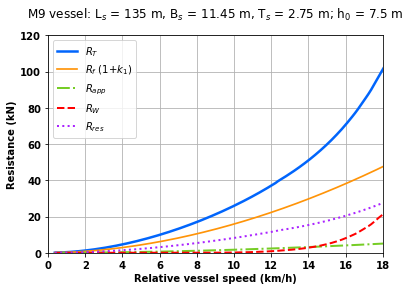

In [10]:
# resistance for water depth h_0 = 7.5 m, 1990
selected = plot_df.query('C_year == 1990 and h_0 == 7.5')

plt.figure(figsize=(6,4))
plt.plot(selected['V_s_km'], selected['R_T'], color='#0165fc', linewidth = 2.5)       # RT, total resistance of the ship,[kN] 
plt.plot(selected['V_s_km'], selected['R_f_one_k1'],color='#ff9408', linewidth = 1.7) # Rf(1+k1), frictional resistance including the hull form factor
plt.plot(selected['V_s_km'], selected['R_APP'],'-.', color='#76cd26',linewidth = 2)   # Rapp, appendage resistance
plt.plot(selected['V_s_km'], selected['R_W'], 'r--', linewidth = 2)                   # Rw, wave resistance
plt.plot(selected['V_s_km'], selected['R_res'],':',color='#aa23ff', linewidth = 2) # Rres, residual resistance
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 120)
plt.legend(['$R_T$', '$R_f$$\ $(1+$k_1$)', '$R_{app}$', '$R_W$','$R_{res}$'])
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')

plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m; h$_0$ = 7.5 m',y=1.05)
plt.savefig('Fig_03.pdf', dpi=600, format='pdf') 
#plt.savefig('PartIV-05-04.eps', dpi=600, format='eps') 


### Figure 5: Total required power

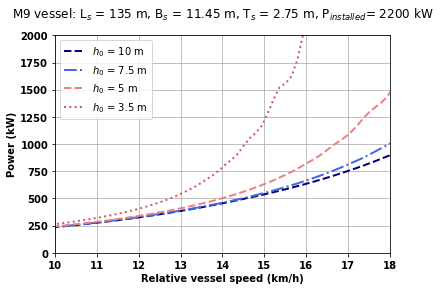

In [11]:

plt.figure(figsize = (6,4))
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)

plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'])

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW' ,y=1.05)
plt.savefig('Fig_05.pdf', dpi=600, format='pdf') 


### Figure 7: validation_total power required versus speed with diff water depths (add DST results to Fig.5)

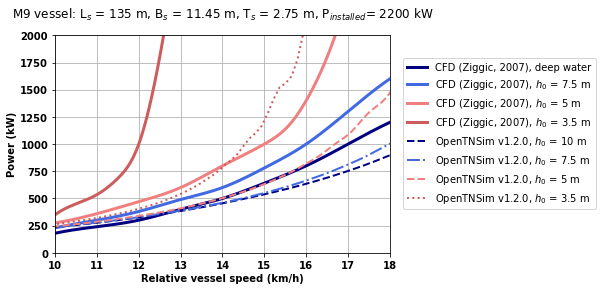

In [12]:
from scipy.interpolate import make_interp_spline, BSpline

plt.figure(figsize = (6,4))
V_DST_1=np.array([10,11,12,13,14,15,16,17,18]) # deep water
P_DST_1=np.array([180,240,300,400,500,640,800,1000,1200])
V_DST_2=np.array([10,11,12,13,14,15,16,17,18]) # h=7.5 m
P_DST_2=np.array([230,300,380,490,600,780,1000,1300,1600])
V_DST_3=np.array([10,11,12,13,14,15,15.65,16,16.5,16.7]) # h=5 m
P_DST_3=np.array([275,360,470,600,800,1000,1200,1400,1800,2005])
V_DST_4=np.array([10,10.5,11,11.5,12,12.5,13]) # h=3.5 m
P_DST_4=np.array([350,450,535,685,1000,1800,3000])
#define spline, make the lines smooth
V_DST_1_new = np.linspace(V_DST_1.min(), V_DST_1.max(), 200) 
V_DST_2_new = np.linspace(V_DST_2.min(), V_DST_2.max(), 200) 
V_DST_3_new = np.linspace(V_DST_3.min(), V_DST_3.max(), 200) 
V_DST_4_new = np.linspace(V_DST_4.min(), V_DST_4.max(), 200) 

spl1= make_interp_spline(V_DST_1,P_DST_1, k=3)
P_DST_1_new = spl1(V_DST_1_new)
spl2= make_interp_spline(V_DST_2,P_DST_2, k=3)
P_DST_2_new = spl2(V_DST_2_new)
spl3= make_interp_spline(V_DST_3,P_DST_3, k=3)
P_DST_3_new = spl3(V_DST_3_new)
spl4= make_interp_spline(V_DST_4,P_DST_4, k=3)
P_DST_4_new = spl4(V_DST_4_new)
                 
plt.plot(V_DST_1_new,P_DST_1_new,color='navy',linewidth = 3.0)
plt.plot(V_DST_2_new,P_DST_2_new,color='royalblue',linewidth = 3.0)
plt.plot(V_DST_3_new,P_DST_3_new,color='lightcoral',linewidth = 3.0)
plt.plot(V_DST_4_new,P_DST_4_new,color='indianred',linewidth = 3.0)

# selected = plot_df.query('c_year == 1990 and h_0 == 150 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='red',linewidth = 2.0)
# selected = plot_df.query('c_year == 1990 and h_0 == 50 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='orange',linewidth = 2.0)
# selected = plot_df.query('c_year == 1990 and h_0 == 20 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='yellow',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)
plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['CFD (Ziggic, 2007), deep water', 'CFD (Ziggic, 2007), $h_0$ = 7.5 m', 'CFD (Ziggic, 2007), $h_0$ = 5 m', 'CFD (Ziggic, 2007), $h_0$ = 3.5 m',
        'OpenTNSim v1.2.0, $h_0$ = 10 m', 'OpenTNSim v1.2.0, $h_0$ = 7.5 m', 'OpenTNSim v1.2.0, $h_0$ = 5 m', 'OpenTNSim v1.2.0, $h_0$ = 3.5 m'],loc=(1.04,0.2))

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
#plt.title('total power required versus speed with diff water depths (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m)')
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW',y=1.05)
plt.savefig('Fig_07_with_squat.pdf',bbox_inches = 'tight',dpi=600, format='pdf') 


### Figure 8: Emissions as a function of vessel speed: emission rates in g/km versus speed for different water depths

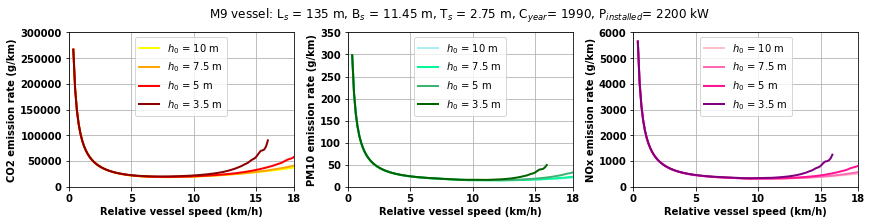

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10


ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'yellow',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'orange',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'red',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkred',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)  #  set vessel speed range (km/h) for inland shipping
plt.ylim(0, 300000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


ax=plt.subplot(132)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'paleturquoise',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumspringgreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumseagreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'darkgreen',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 350)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990, P$_{installed}$= 2200 kW',y=1.05)

ax=plt.subplot(133)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'pink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'hotpink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'deeppink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'purple',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 6000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


plt.savefig('Fig_08.pdf', dpi=600, format='pdf')  
#plt.savefig('PartIV-05-09.eps', dpi=600, format='eps') 

### Figure 9: Emissions as a function of engine age: emission rates in g/km versus speed for different engine ages


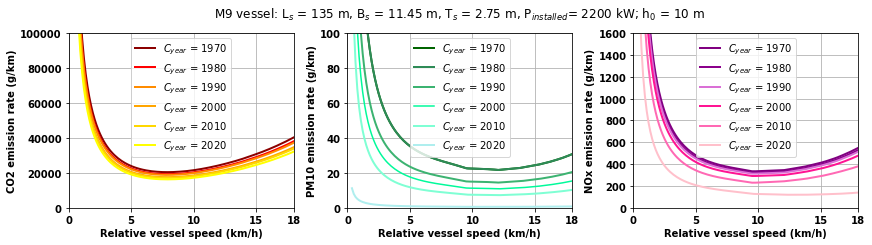

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.3),constrained_layout=True)
fontsize=10

ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkred',linewidth = 2.0)   

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'red',linewidth = 2.0)      

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkorange',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'orange',linewidth = 2.0)    

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'gold',linewidth = 2.0)      

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'yellow',linewidth = 2.0)    

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18],weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(132)
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'darkgreen',linewidth = 2.0)

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'seagreen',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumseagreen',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumspringgreen')

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'aquamarine',linewidth = 2.0)

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'paleturquoise',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW; h$_0$ = 10 m',y=1.05)

ax=plt.subplot(133)
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'purple',linewidth = 2.0)

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'darkmagenta',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'orchid',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'deeppink',linewidth = 2.0)

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'hotpink',linewidth = 2.0)

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'pink',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000',
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 1600)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

plt.savefig('Fig_09.pdf', dpi=600, format='pdf')
#plt.savefig('PartIV-05-10.eps', dpi=600, format='eps')
#fig.suptitle('Emission rate versus velocity, for different engine ages  \n (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m, h = 10 m)')